In [87]:
# pytho=3.6.5
# keras=2.2.4
# tensorflow=1.11.0
# pillow=5.1.0
# numpy=1.15.2

# Load data

In [1]:
from keras.datasets import mnist
from PIL import Image
import numpy as np
from keras.utils import to_categorical
from sklearn.utils import shuffle
import time
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras import optimizers
from keras import backend as K
import matplotlib.pyplot as plt

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# --------------------- processing data ----------------------
# loading data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
num_classes = 10

# form one hot label
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def resize_image(data):
    img = Image.fromarray(data.reshape(28,28))
    img = img.resize(size=(32,32))
    return np.array(img)

# preprocessing: resize to 32,32. scale to [0,1]
X_train = np.array([resize_image(x) for x in X_train])
X_test = np.array([resize_image(x) for x in X_test])

# Build NN

In [10]:
# ------------------- create model -------------------
img_rows, img_cols = 32, 32
def build_model(regulaizer=None):
    model = Sequential()
    # add model layers


    # 32, 32
    channel_multiply = 8

    model.add(Conv2D(1 * channel_multiply, (3, 3), activation='relu', padding='same',
                     input_shape=(32,32,1), kernel_regularizer=regulaizer))
    # 32, 32
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    # 16, 16
    model.add(Conv2D(2 * channel_multiply, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regulaizer))
    # 16, 16
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    # 8, 8
    model.add(Conv2D(4 * channel_multiply, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regulaizer))
    # 8, 8
    model.add(Conv2D(4 * channel_multiply, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regulaizer))
    # 8, 8
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    # 4, 4
    model.add(Conv2D(8 * channel_multiply, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regulaizer))
    # 4, 4
    model.add(Conv2D(8 * channel_multiply, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regulaizer))
    # 4, 4
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    # 2, 2
    model.add(Conv2D(8 * channel_multiply, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regulaizer))
    # 2, 2
    model.add(Conv2D(8 * channel_multiply, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regulaizer))
    # 2, 2
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    # 1, 1
    model.add(Flatten())
    model.add(Dense(4 * channel_multiply, kernel_regularizer=regulaizer))
    model.add(Dense(4 * channel_multiply, kernel_regularizer=regulaizer))
    # model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return(model)

In [21]:
# plot
def plot_img(Y1, Y2, title, legend =['train', 'test']):
    plt.clf()
    plt.plot(Y1)
    plt.plot(Y2)
    plt.title(title)
    plt.ylabel(title)
    plt.xlabel('epoch')
    plt.legend(legend, loc='upper left')
    plt.savefig(title + '.png')



# training

In [72]:
model = build_model()
sgd = optimizers.SGD(lr=1e-8, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adamax(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-5)
ada = optimizers.Adadelta()
n = X_train.shape[0]
m = X_test.shape[0]
X_train_ = X_train.reshape(n,32,32,1).astype('float32')
X_train_ /= 255.0
epoches = 5
model.compile(optimizer=adam, loss=keras.losses.categorical_crossentropy, 
              metrics=['accuracy'])
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0,
                                         write_graph=True, write_images=True)
history = model.fit(X_train_, y_train, validation_split=0.2, 
                    epochs=epoches, batch_size=32, callbacks=[tbCallBack], verbose=True)

print(history.history['acc'][-1],'\t',history.history['loss'][-1],'\t',
      history.history['val_acc'][-1],'\t',history.history['val_loss'][-1])


Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 45s 932us/step - loss: 0.3528 - acc: 0.8818 - val_loss: 0.1087 - val_acc: 0.9677
Epoch 2/5
48000/48000 [==============================] - 43s 891us/step - loss: 0.0995 - acc: 0.9690 - val_loss: 0.0994 - val_acc: 0.9702
Epoch 3/5
48000/48000 [==============================] - 41s 856us/step - loss: 0.0684 - acc: 0.9785 - val_loss: 0.0735 - val_acc: 0.9782
Epoch 4/5
48000/48000 [==============================] - 37s 764us/step - loss: 0.0514 - acc: 0.9844 - val_loss: 0.0653 - val_acc: 0.9808
Epoch 5/5
48000/48000 [==============================] - 37s 768us/step - loss: 0.0413 - acc: 0.9866 - val_loss: 0.0624 - val_acc: 0.9810
0.9866458333333333 	 0.04132930671690459 	 0.981 	 0.06235547045886051


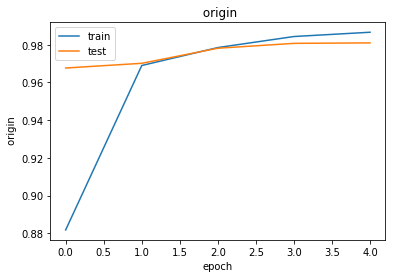

In [73]:
plot_img(history.history['acc'], history.history['val_acc'], " origin")

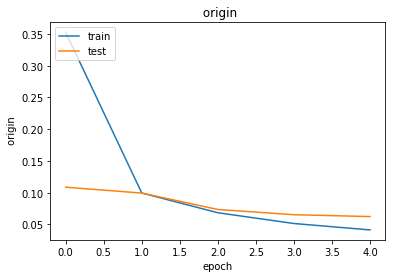

In [74]:
plot_img(history.history['loss'], history.history['val_loss'], " origin")

## Rotation & blur test

In [75]:
from matplotlib import pyplot as plt

def rotation_imgs(X, degree):
    size = 32,32
    ans = []
    for x in X:
        img = Image.fromarray(x.reshape(size), mode='L')
        ans.append(np.array(img.rotate(degree)))
    #print(np.array(ans).shape)
    return np.array(ans)

from PIL import ImageFilter
def blur_imgs(X, radius):
    size = 32,32
    ans = []
    for x in X:
        img = Image.fromarray(x.reshape(size), mode='L')
        ans.append(np.array(img.filter(ImageFilter.GaussianBlur(radius=radius))))
    return np.array(ans) 

In [76]:
X_test[0]
m = 10000

rotation_loss = []
rotation_acc = []
for rotation in range(-45,50,5):
    X_test_ = rotation_imgs(X_test, rotation).reshape(m, 32,32,1).astype('float32') / 255.0
    result = model.evaluate(x=X_test_, y=y_test,verbose=0)
    rotation_loss.append(result[0])
    rotation_acc.append(result[1])

blur_loss = []
blur_acc = []
for blur in range(8):
    X_test_ = blur_imgs(X_test, blur).reshape(m, 32,32,1).astype('float32') / 255.0
    result = model.evaluate(x=X_test_, y=y_test,verbose=0)
    blur_loss.append(result[0])
    blur_acc.append(result[1])

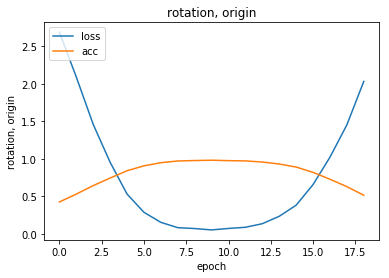

In [77]:
plot_img(rotation_loss, rotation_acc,'rotation, origin', legend=['loss','acc'])

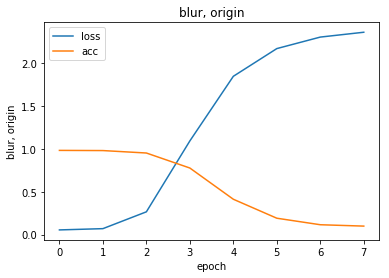

In [79]:
plot_img(blur_loss, blur_acc,'blur, origin', legend=['loss','acc'])

# L2 normalization

In [80]:
model = build_model(regulaizer=keras.regularizers.l2(0.001))
sgd = optimizers.SGD(lr=1e-8, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adamax(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-5)
ada = optimizers.Adadelta()
n = X_train.shape[0]
m = X_test.shape[0]
X_train_ = X_train.reshape(n,32,32,1).astype('float32')
X_train_ /= 255.0
epoches = 5
model.compile(optimizer=adam, loss=keras.losses.categorical_crossentropy, 
              metrics=['accuracy'])
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0,
                                         write_graph=True, write_images=True)
history = model.fit(X_train_, y_train, validation_split=0.2, 
                    epochs=epoches, batch_size=32, callbacks=[tbCallBack], verbose=True)

print(history.history['acc'][-1],'\t',history.history['loss'][-1],'\t',
      history.history['val_acc'][-1],'\t',history.history['val_loss'][-1])


Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 45s 945us/step - loss: 0.6827 - acc: 0.8565 - val_loss: 0.3941 - val_acc: 0.9491
Epoch 2/5
48000/48000 [==============================] - 42s 881us/step - loss: 0.3442 - acc: 0.9629 - val_loss: 0.3012 - val_acc: 0.9740
Epoch 3/5
48000/48000 [==============================] - 39s 817us/step - loss: 0.2868 - acc: 0.9742 - val_loss: 0.2834 - val_acc: 0.9712
Epoch 4/5
48000/48000 [==============================] - 39s 820us/step - loss: 0.2519 - acc: 0.9787 - val_loss: 0.2633 - val_acc: 0.9700
Epoch 5/5
48000/48000 [==============================] - 41s 859us/step - loss: 0.2267 - acc: 0.9816 - val_loss: 0.2216 - val_acc: 0.9805
0.981625 	 0.22671355097492535 	 0.9805 	 0.22156857776641845


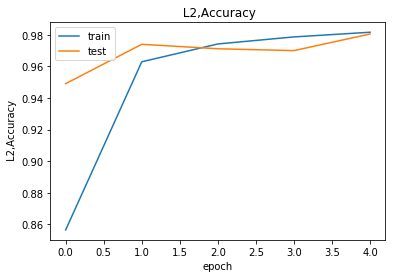

In [81]:
plot_img(history.history['acc'], history.history['val_acc'], " L2,Accuracy")

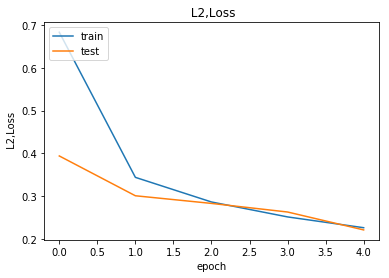

In [82]:
plot_img(history.history['loss'], history.history['val_loss'], " L2,Loss")

## rotation & blur test

In [84]:
X_test[0]
m = 10000

rotation_loss = []
rotation_acc = []
for rotation in range(-45,50,5):
    X_test_ = rotation_imgs(X_test, rotation).reshape(m, 32,32,1).astype('float32') / 255.0
    result = model.evaluate(x=X_test_, y=y_test,verbose=0)
    rotation_loss.append(result[0])
    rotation_acc.append(result[1])

blur_loss = []
blur_acc = []
for blur in range(8):
    X_test_ = blur_imgs(X_test, blur).reshape(m, 32,32,1).astype('float32') / 255.0
    result = model.evaluate(x=X_test_, y=y_test,verbose=0)
    blur_loss.append(result[0])
    blur_acc.append(result[1])

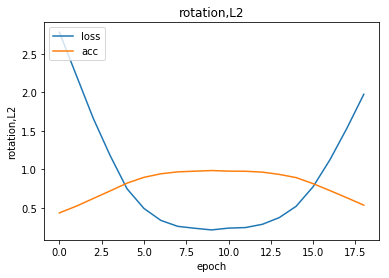

In [85]:
plot_img(rotation_loss, rotation_acc,'rotation,L2', legend=['loss','acc'])

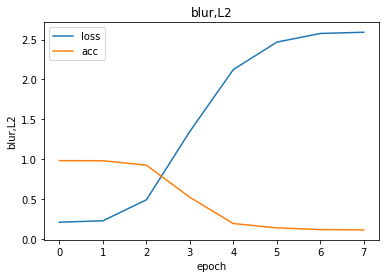

In [86]:
plot_img(blur_loss, blur_acc,'blur,L2', legend=['loss','acc'])

# data augmentation

In [94]:
import random
from tqdm import trange
batch_size = 60
X_train_aug = np.array([X_train[0]])
y_train_aug = np.array([y_train[0]])
n = 60000
l = 0
for i in trange(6000):
    rotation = int(random.random()*90) - 45
    r = l + batch_size
    if r > n:
        r = n
    #print(X_train_aug.shape)
    X_train_aug = np.concatenate((X_train_aug, rotation_imgs(X_train[l:r], rotation)), axis=0)
    y_train_aug = np.concatenate((y_train_aug, y_train[l:r]), axis=0)
    l = r
    if r == n:
        l = 0

for i in trange(4000):
    blur = int(random.random()*8)
    r = l + batch_size
    if r > n:
        r = n
    X_train_aug = np.concatenate((X_train_aug, blur_imgs(X_train[l:r], rotation)), axis=0)
    y_train_aug = np.concatenate((y_train_aug, y_train[l:r]), axis=0)
    l = r
    if r == n:
        l = 0     
n_ = len(X_train_aug)


100%|██████████| 4000/4000 [00:50<00:00, 78.46it/s]


In [95]:
X_train_aug_ = np.array(X_train_aug).reshape(n_, 32,32,1).astype("float32")
y_train_aug = np.array(y_train_aug)

In [96]:
model = build_model(regulaizer=keras.regularizers.l2(0.001))
sgd = optimizers.SGD(lr=1e-8, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adamax(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-5)
ada = optimizers.Adadelta()
n = X_train.shape[0]
m = X_test.shape[0]
X_train_ = X_train.reshape(n,32,32,1).astype('float32')
X_train_ /= 255.0
epoches = 5
model.compile(optimizer=adam, loss=keras.losses.categorical_crossentropy, 
              metrics=['accuracy'])
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0,
                                         write_graph=True, write_images=True)
history = model.fit(X_train_aug_, y_train_aug, validation_split=0.2, 
                    epochs=epoches, batch_size=32, callbacks=[tbCallBack], verbose=True)

print(history.history['acc'][-1],'\t',history.history['loss'][-1],'\t',
      history.history['val_acc'][-1],'\t',history.history['val_loss'][-1])

Train on 480000 samples, validate on 120001 samples
Epoch 1/5
480000/480000 [==============================] - 421s 877us/step - loss: 0.8404 - acc: 0.7718 - val_loss: 2.2170 - val_acc: 0.2228
Epoch 2/5
480000/480000 [==============================] - 422s 879us/step - loss: 0.6705 - acc: 0.7920 - val_loss: 2.1663 - val_acc: 0.2179
Epoch 3/5
480000/480000 [==============================] - 424s 882us/step - loss: 0.6314 - acc: 0.7946 - val_loss: 2.1442 - val_acc: 0.2246
Epoch 4/5
480000/480000 [==============================] - 407s 848us/step - loss: 0.6142 - acc: 0.7964 - val_loss: 2.1325 - val_acc: 0.2202
Epoch 5/5
480000/480000 [==============================] - 428s 892us/step - loss: 0.6043 - acc: 0.7974 - val_loss: 2.1310 - val_acc: 0.2221
0.7973645833333334 	 0.6043062019536892 	 0.22211481570986907 	 2.1309856843138144


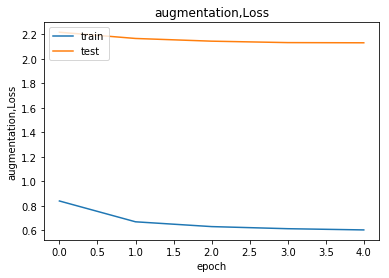

In [97]:
plot_img(history.history['loss'], history.history['val_loss'], "augmentation,Loss")

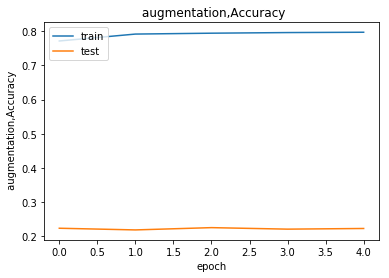

In [98]:
plot_img(history.history['acc'], history.history['val_acc'], " augmentation,Accuracy")

In [99]:
X_test[0]
m = 10000

rotation_loss = []
rotation_acc = []
for rotation in range(-45,50,5):
    X_test_ = rotation_imgs(X_test, rotation).reshape(m, 32,32,1).astype('float32') / 255.0
    result = model.evaluate(x=X_test_, y=y_test,verbose=0)
    rotation_loss.append(result[0])
    rotation_acc.append(result[1])

blur_loss = []
blur_acc = []
for blur in range(8):
    X_test_ = blur_imgs(X_test, blur).reshape(m, 32,32,1).astype('float32') / 255.0
    result = model.evaluate(x=X_test_, y=y_test,verbose=0)
    blur_loss.append(result[0])
    blur_acc.append(result[1])

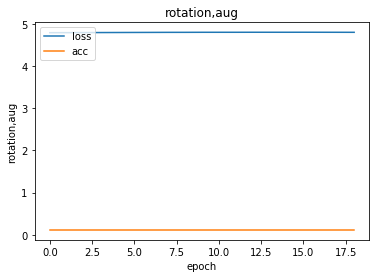

In [100]:
plot_img(rotation_loss, rotation_acc,'rotation,aug', legend=['loss','acc'])

In [101]:
rotation_loss

[4.794475444030762,
 4.795473281860351,
 4.796756427764892,
 4.797971002197266,
 4.799232973480224,
 4.800467929840088,
 4.801571029663086,
 4.802796955871582,
 4.803222702789307,
 4.804254311370849,
 4.80436909866333,
 4.804502542877198,
 4.805042118072509,
 4.804980780029297,
 4.804879172515869,
 4.805288863372803,
 4.80486296081543,
 4.804383746337891,
 4.803662870025635]

In [102]:
rotation_acc

[0.1135,
 0.1135,
 0.1135,
 0.1135,
 0.1135,
 0.1135,
 0.1135,
 0.1135,
 0.1135,
 0.1135,
 0.1135,
 0.1135,
 0.1135,
 0.1135,
 0.1135,
 0.1135,
 0.1135,
 0.1135,
 0.1135]

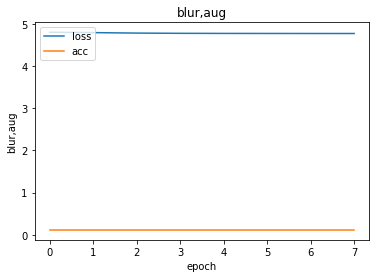

In [103]:
plot_img(blur_loss, blur_acc,'blur,aug', legend=['loss','acc'])

In [104]:
blur_loss

[4.804254311370849,
 4.795392660522461,
 4.784180256652832,
 4.778575176239014,
 4.77641001663208,
 4.7753419677734374,
 4.77462678527832,
 4.774129472351074]

In [105]:
blur_acc

[0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135]